In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

BASE_DIR = '/home/mgraca/Workspace/hrrr-smoke-viz'
CACHE_DIR = f'{BASE_DIR}/pwwb-experiments/tensorflow/cached_data/two_years_sat_data'
AIRNOW_JSON_PATH = f'{CACHE_DIR}/airnow_cache/airnow.json'
sys.path.append(BASE_DIR)

START_DATE = "2023-08-02-00"
END_DATE = "2025-08-02-00"

In [2]:
# load original json data
data = pd.read_json(AIRNOW_JSON_PATH)
original_data = data.copy()

# remove sensors that have <25% uptime
def remove_underreporting_sensors(df, min_uptime=0.25):
    timesteps = len(df.groupby('UTC').count())
    return df.groupby('FullAQSCode').filter(lambda x : len(x) / timesteps > min_uptime).copy()

# replace invalid pm2.5 values with nan
def impute_invalid_values_with_nan(df):
    df.loc[df['Value'] < 0, 'Value'] = np.nan
    return df

# generate samples from sensors that are not reporting; set values to nan
def generate_samples_from_time(df, start_date, end_date):
    dates_df = pd.DataFrame({'UTC': pd.date_range(start_date, end_date, inclusive='left', freq='h')})
    df['UTC'] = pd.to_datetime(df['UTC'])
    cols_to_interpolate = [
        'Latitude', 'Longitude', 'Parameter', 'Unit', 
        'SiteName', 'AgencyName', 'FullAQSCode', 'IntlAQSCode'
    ]
    sensor_dfs = []
    for col in df['FullAQSCode'].unique():
        a = pd.merge(dates_df, df.loc[df['FullAQSCode'] == col], on='UTC', how='left')
        a[cols_to_interpolate] = a[cols_to_interpolate].ffill().bfill()
        sensor_dfs.append(a)
    return pd.concat(sensor_dfs, ignore_index=True)

# impute outlier sensor data with nan
def impute_outliers_with_nan(df, zscore=3):
    sensor_group = df.groupby('FullAQSCode')['Value']
    zscore_per_sensor_group = (df['Value'] - sensor_group.transform('mean')) / sensor_group.transform('std')
    df['Value'] = np.where(np.abs(zscore_per_sensor_group) > zscore, np.nan, df['Value'])
    return df

# replace all nans with a forward and back fill
def impute_nans_with_fbfill(df):
    df['Value'] = (
        df
        .sort_values(['FullAQSCode', 'UTC'])
        .groupby('FullAQSCode')['Value']
        .transform(lambda s: s.ffill().bfill())
    )
    return df

filtered_data = remove_underreporting_sensors(original_data)
filtered_data = impute_invalid_values_with_nan(filtered_data)
filtered_data = generate_samples_from_time(filtered_data, START_DATE, END_DATE)
filtered_data = impute_outliers_with_nan(filtered_data)
filtered_data = impute_nans_with_fbfill(filtered_data)

filtered_data.groupby(['FullAQSCode', 'SiteName'])['Value'].describe()

,,count,mean,std,min,25%,50%,75%,max
FullAQSCode,SiteName,,,,,,,,
060370016,Glendora - Laurel,17544.0,9.157438,6.351313,0.0,4.4,8.5,12.7,41.1
060371103,Los Angeles - N. Main Street,17544.0,12.559131,6.786640,0.0,7.9,11.4,15.8,44.0
060371201,Reseda,17544.0,9.851265,5.647506,0.0,6.0,9.3,12.8,31.3
060371302,Compton,17544.0,11.951995,7.754643,0.0,6.7,10.3,14.9,44.3
060376012,Santa Clarita,17544.0,9.642909,4.356610,0.0,6.4,9.2,12.4,23.8
060590007,Anaheim,17544.0,11.079549,6.046920,0.0,7.0,10.1,13.9,34.3
060650016,Temecula (Lake Skinner),17544.0,7.034587,3.737096,0.0,4.3,6.8,9.4,19.2
060658001,Riverside - Rubidoux,17544.0,11.629748,7.238258,0.0,6.5,10.6,15.4,37.7
060658005,Mira Loma - Van Buren,17544.0,13.122612,8.234972,0.0,7.6,11.7,16.9,43.2


In [3]:
# check that saving and loading doesn't change anything
filtered_data.to_json(f'{CACHE_DIR}/airnow_cache/airnow_processed.json', date_format='iso', date_unit='s', orient='records', indent=4)
peek = pd.read_json(f'{CACHE_DIR}/airnow_cache/airnow_processed.json')
peek.groupby(['FullAQSCode', 'SiteName'])['Value'].describe()

,,count,mean,std,min,25%,50%,75%,max
FullAQSCode,SiteName,,,,,,,,
60370016,Glendora - Laurel,17544.0,9.157438,6.351313,0.0,4.4,8.5,12.7,41.1
60371103,Los Angeles - N. Main Street,17544.0,12.559131,6.786640,0.0,7.9,11.4,15.8,44.0
60371201,Reseda,17544.0,9.851265,5.647506,0.0,6.0,9.3,12.8,31.3
60371302,Compton,17544.0,11.951995,7.754643,0.0,6.7,10.3,14.9,44.3
60376012,Santa Clarita,17544.0,9.642909,4.356610,0.0,6.4,9.2,12.4,23.8
60590007,Anaheim,17544.0,11.079549,6.046920,0.0,7.0,10.1,13.9,34.3
60650016,Temecula (Lake Skinner),17544.0,7.034587,3.737096,0.0,4.3,6.8,9.4,19.2
60658001,Riverside - Rubidoux,17544.0,11.629748,7.238258,0.0,6.5,10.6,15.4,37.7
60658005,Mira Loma - Van Buren,17544.0,13.122612,8.234972,0.0,7.6,11.7,16.9,43.2


In [4]:
peek

,UTC,Latitude,Longitude,Parameter,Unit,Value,RawConcentration,AQI,Category,SiteName,AgencyName,FullAQSCode,IntlAQSCode
0,2023-08-02T00:00:00,34.276320,-118.683690,PM2.5,UG/M3,9.8,8.0,52.0,2.0,Simi Valley - Cochran Street,Ventura County APCD,61112002,840061112002
1,2023-08-02T01:00:00,34.276320,-118.683690,PM2.5,UG/M3,11.4,13.0,55.0,2.0,Simi Valley - Cochran Street,Ventura County APCD,61112002,840061112002
2,2023-08-02T02:00:00,34.276320,-118.683690,PM2.5,UG/M3,14.2,17.0,61.0,2.0,Simi Valley - Cochran Street,Ventura County APCD,61112002,840061112002
3,2023-08-02T03:00:00,34.276320,-118.683690,PM2.5,UG/M3,12.6,11.0,58.0,2.0,Simi Valley - Cochran Street,Ventura County APCD,61112002,840061112002
4,2023-08-02T04:00:00,34.276320,-118.683690,PM2.5,UG/M3,12.3,12.0,57.0,2.0,Simi Valley - Cochran Street,Ventura County APCD,61112002,840061112002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
263155,2025-08-01T19:00:00,33.583099,-117.072197,PM2.5,UG/M3,7.1,6.2,39.0,1.0,Temecula (Lake Skinner),South Coast AQMD,60650016,840060650016
263156,2025-08-01T20:00:00,33.583099,-117.072197,PM2.5,UG/M3,8.3,9.4,46.0,1.0,Temecula (Lake Skinner),South Coast AQMD,60650016,840060650016
263157,2025-08-01T21:00:00,33.583099,-117.072197,PM2.5,UG/M3,7.8,7.2,43.0,1.0,Temecula (Lake Skinner),South Coast AQMD,60650016,840060650016
263158,2025-08-01T22:00:00,33.583099,-117.072197,PM2.5,UG/M3,7.1,6.5,39.0,1.0,Temecula (Lake Skinner),South Coast AQMD,60650016,840060650016


In [5]:
from libs.airnowdata import AirNowData
AND = AirNowData(
    save_dir=f'{CACHE_DIR}/airnow_cache/airnow_processed.json',
    processed_cache_dir=f'{CACHE_DIR}/airnow_cache/airnow_processing_experiments.npz',
    idw_power=1.5,
    elevation_path=None,
    force_reprocess=False,
    use_interpolation=True, # determines if interpolation should be run
    use_variable_blur=False,# determines if variable blur is used after interpolation
    verbose=0,              # 0=allow all, 1=progress bar only, 2=silence all except warning
)

print(AND.data.shape)
print(AND.air_sens_loc)

Loading processed AirNow data from cache: /home/mgraca/Workspace/hrrr-smoke-viz/pwwb-experiments/tensorflow/cached_data/two_years_sat_data/airnow_cache/airnow_processing_experiments.npz
✓ Successfully loaded processed data from cache
  - Data shape: (17544, 40, 40)
  - Found 15 sensor locations
(17544, 40, 40)
{'Simi Valley - Cochran Street': (8, 1), 'Reseda': (12, 4), 'Santa Clarita': (4, 5), 'North Holywood': (12, 8), 'Los Angeles - N. Main Street': (17, 11), 'Compton': (23, 12), 'Long Beach Signal Hill': (28, 13), 'Anaheim': (26, 18), 'Glendora - Laurel': (14, 20), 'Mira Loma - Van Buren': (20, 28), 'Fontana - Arrow Highway': (15, 28), 'Riverside - Rubidoux': (20, 30), 'Lake Elsinore - W. Flint Street': (32, 32), 'Crestline - Lake Gregory': (10, 33), 'Temecula (Lake Skinner)': (36, 38)}


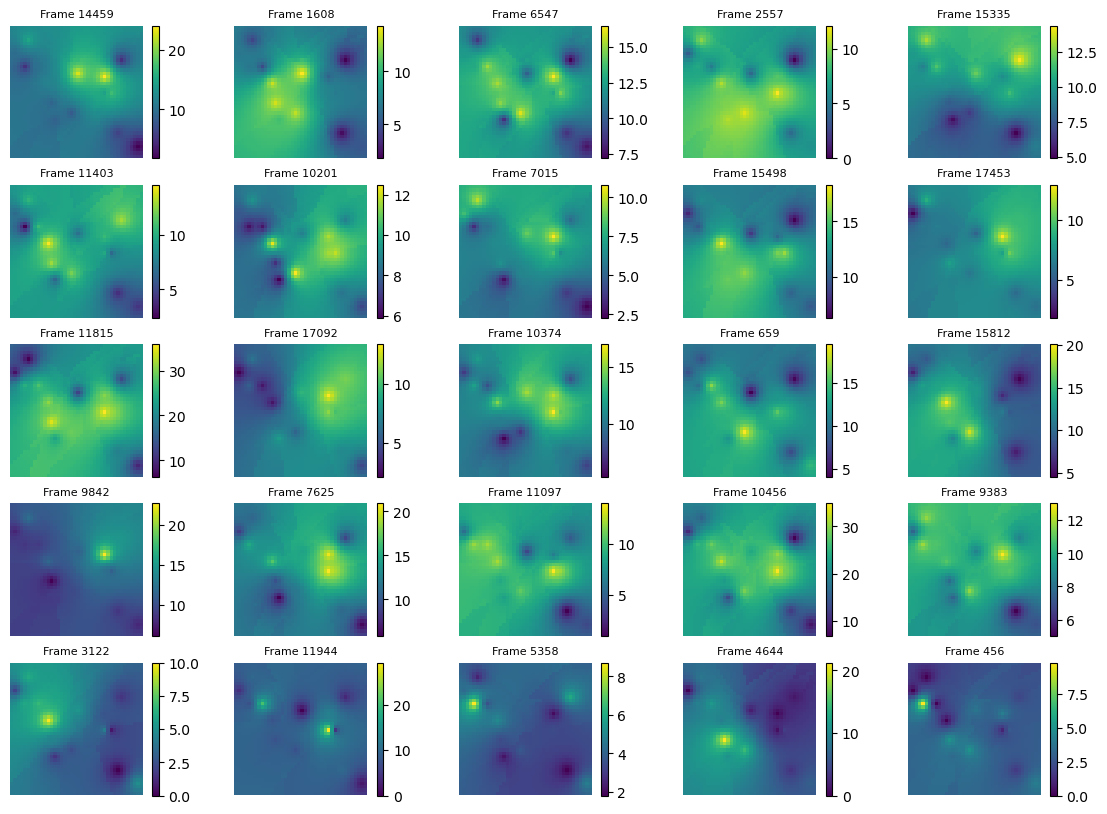

In [14]:
def random_frame_plotter(images, rows=5, cols=5):
    indices = np.random.choice(images.shape[0], size=rows*cols, replace=False)
    fig, axes = plt.subplots(rows, cols, figsize=(14, 10))
    
    for ax, idx in zip(axes.flat, indices):
        im = ax.imshow(images[idx])
        ax.axis('off') 
        ax.set_title(f"Frame {idx}", fontsize=8)
        fig.colorbar(im, ax=ax)
    #plt.tight_layout()
    plt.show()
random_frame_plotter(AND.data)

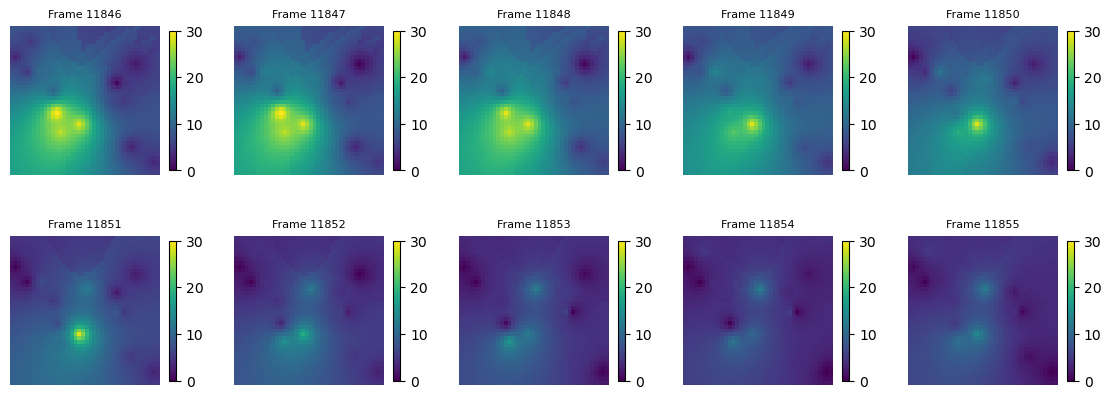

In [11]:
def straight_frame_plotter(images, idx, rows=2, cols=5):
    indices = range(idx-5, idx+5)
    fig, axes = plt.subplots(rows, cols, figsize=(14, 5))
    
    for ax, idx in zip(axes.flat, indices):
        im = ax.imshow(images[idx], vmin=0, vmax=30)
        ax.axis('off') 
        ax.set_title(f"Frame {idx}", fontsize=8)
        fig.colorbar(im, ax=ax, shrink=0.8)
    
    plt.show()
straight_frame_plotter(AND.data, 11851)

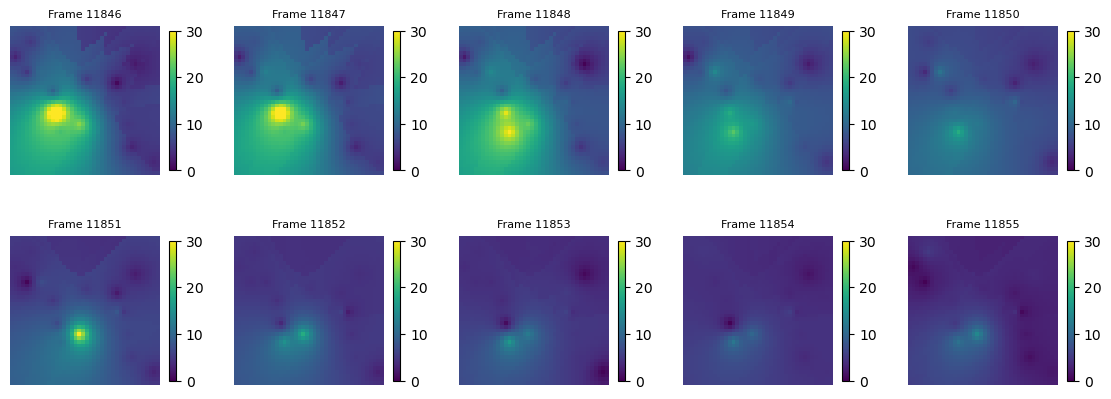

In [12]:
old_processed = np.load(f'{CACHE_DIR}/airnow_cache/airnow_processed.npz')['data']
straight_frame_plotter(old_processed, 11851)

In [13]:
# notice 8 and 9 (anaheim, glendora) standing out due to copying previous frame
X, Y = zip(*AND.air_sens_loc.values())
AND.data[11851-5:11851+5, X, Y]

array([[ 3. ,  4.9,  5. , 10.4,  9.4, 32.1, 27.1, 28.5, 12.4,  6. ,  0.7,
         5. ,  3.1,  2. ,  3.5],
       [ 2.5,  6.6,  7.5, 13. ,  8.9, 32.1, 27.1, 28.5, 12.4,  7.8,  2.4,
         5.5,  3.3,  0. ,  4.8],
       [ 2.2,  9.1,  7.6, 14. ,  9.3, 28.9, 27.1, 28.5, 12.4,  9.7,  5.5,
         7.5,  4.5,  0.2,  5.7],
       [ 1.1,  7.6,  6.4, 14. ,  8. , 18.5, 22.2, 28.5, 12.4, 10.4,  5.2,
         7.8,  7.2,  2.2,  4.7],
       [ 0. ,  3.6,  5.4, 11.5,  5.7, 11.5, 18.7, 28.5, 12.4,  9.9,  3. ,
         6.7,  7.3,  2.6,  3.4],
       [ 0. ,  0.4,  4.4,  7. ,  4.9,  6.7, 10.8, 28.5, 12.4,  8.1,  2.2,
         4.9,  5.2,  2.4,  3.1],
       [ 0. ,  0. ,  4.1,  4.1,  4.2,  3.5, 15.2, 18.6, 12.4,  5.8,  4. ,
         2.3,  4.9,  0. ,  2.8],
       [ 0. ,  0. ,  4. ,  3.8,  3.7,  0.9, 16.3, 12.4, 12.4,  5.9,  5.2,
         0. ,  4.4,  0.6,  0.3],
       [ 0. ,  0. ,  4.8,  3.8,  3.9,  0.2, 11.9,  9.9, 12.4,  5.6,  3.2,
         0. ,  3.6,  1.5,  0. ],
       [ 0.6,  0.2,  5.1,  3. ,  4. ,

In [10]:
old_processed[11851-5:11851+5, X, Y]

array([[ 3.       ,  4.9      ,  5.       , 10.4      ,  9.4      ,
        43.8      , 21.2      , 24.8      ,  5.366667 ,  6.       ,
         0.7      ,  5.       ,  3.1      ,  2.       ,  3.5      ],
       [ 2.5      ,  6.6      ,  7.5      , 13.       ,  8.9      ,
        41.2      , 21.033333 , 23.711111 ,  6.366667 ,  7.8      ,
         2.4      ,  5.5      ,  3.3      ,  5.233333 ,  4.8      ],
       [ 2.2      ,  9.1      ,  7.6      , 14.       ,  9.3      ,
        28.9      , 30.8      , 23.       ,  8.166667 ,  9.7      ,
         5.5      ,  7.5      ,  4.5      ,  0.2      ,  5.7      ],
       [ 1.1      ,  7.6      ,  6.4      , 14.       ,  8.       ,
        18.5      , 22.2      , 16.233334 ,  7.866667 , 10.4      ,
         5.2      ,  7.8      ,  7.2      ,  2.2      ,  4.7      ],
       [ 6.8333335,  3.6      ,  5.4      , 11.5      ,  5.7      ,
        11.5      , 18.7      , 11.966666 ,  6.2      ,  9.9      ,
         3.       ,  6.7      ,  7.3      , 